# Report on BG CV test task

## Artyom V. Vasiliev

#### this notebook has the following structure:

* [0.Problem description](#description)
* [1.0. CNN Image classifier](#image-classifier)
* [1.1. - Data overview](#image-classifier-data-overview)
* [1.2. - Data preprocessing](#image-classifier-data-preprocessing)


## 0. Problem description <a class="anchor" id="description"></a>

**Problem 1:**
> Используя фреймворк pytorch, реализуйте архитектуру для
классификации изображений по стилям художников. Для решения задачи можно
взять достаточно простые архитектуры.
Изображения для обучения необходимо уменьшить до размера 64x64 или
128x128 (при наличии ресурсов). Обучить реализованную модель на
предобработанном датасете. Нарисовать графики изменения значений лосса и
выбранных метрик по эпохам.
Результаты представить в Jupyter ноутбуке.

**Problem 1 extras:** 
> Вместо выхода сети-классификатора используйте одномерный вектор с
предпоследнего слоя сети. Используя этот вектор, как набор признаков для каждого
изображения, попробуйте кластеризовать получившийся датасет векторов любым
подходящим (по вашему мнению) алгоритмом. Попробуйте определить, по каким
признакам различаются полученные кластера.
Используя набор признаков, полученных в предыдущем пункте, примените
XGBoost для решения задачи классификации. Сравните метрики качества XGBoost
и нейронной сети.

**Problem 2:** 
> Необходимо реализовать алгоритм knn(k nearest neighbors) на python и c++ (по
возможности).
Минимальный прототип:
```
def knn(points, k=10)
```
> При необходимости аргументы можно добавлять.
points - матрица размера NxM, где N - количество точек, M-размерность
пространства. В качестве выхода матрица Nxk с индексами ближайших k соседей,
отсортированных по L2 расстоянию. Для теста использовать рандомно
сгенерированные точки. Программа должна работать для значений N, M и k порядка
10^4, 20, 30 соответственно.

**Problem 2 extras:** 
> Добавить в функцию аргумент metric, с помощью которого можно выбирать способ
вычисления расстояния. Реализовать подобный алгоритм для L1 и cosine distance.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os, os.path
import sys
import subprocess

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torchvision.__version__)
print('Using device:', device)

1.5.0
0.6.0
Using device: cuda:0


## 1.0. CNN Image classifier <a class="anchor" id="image-classifier"></a>

Objective to design CNN image classifier is seems to be a common knowledge in a field of CV science. I will refer [the Stanford CS 231n class notes](https://cs231n.github.io/ "CS231n: Convolutional Neural Networks for Visual Recognition") and [tutorial in PyTorch documentation](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial "TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL") for my report.

### 1.1. - Data overview <a class="anchor" id="image-classifier-data-overview"></a> 

Before anything else, let's start from unzipping raw data. File `images_full.zip` should be placed in project root directory.

In [2]:
bashCommand = "unzip images_full.zip"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
bashCommand = "ls images"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
classes = list(filter(None, output.decode("utf-8").split('\n')))
nclasses = len(classes)
print(nclasses, classes)

8 ['ArtDeco', 'cartoon', 'Cubism', 'Impressionism', 'Japonism', 'Naturalism', 'photo', 'Rococo']


One could easily find that images in the given dataset belongs to one of the $8$ different classes. Let's define the available number of samples in each of the classes:

In [3]:
per_class_names = {}
per_class_counts = {}

for cur_class in classes:
    DIR = 'images/{}'.format(cur_class)
    per_class_names[cur_class] = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]
    per_class_counts[cur_class] = len(per_class_names[cur_class])

overall_count = sum(per_class_counts.values())
print(overall_count)
per_class_counts

1422


{'ArtDeco': 65,
 'cartoon': 75,
 'Cubism': 365,
 'Impressionism': 240,
 'Japonism': 203,
 'Naturalism': 218,
 'photo': 139,
 'Rococo': 117}

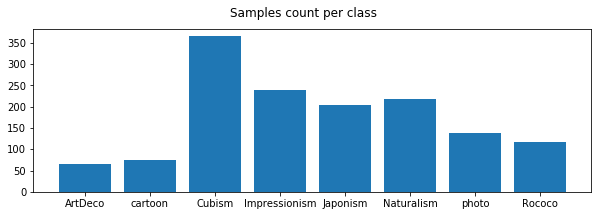

In [4]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(per_class_counts.keys(), per_class_counts.values())
fig.suptitle('Samples count per class')
plt.show()

So classes ArtDeco and cartoon; Impressionism, Japonisme and Naturism; photo and Rococo have about the same representation respectively. Class 'Cubism' is significantly more frequent than any others, while whole dataset is also class-imbalanced (but not dramatically hard).

Since we a not going to either perform mining extra samples for retarded classes (which I hope would be unnecessary according the framework of this test task) or use data augmentation to level imbalance (because of intuitive risk of overfitting on relatevly low ammount of unique samples), we will only use information about class-imbalance in order to choose train-validation-test split strategy. We want relative class frequencies to be approximately preserved in each train and validation data subset and so stratified sampling is about to perform in our solution.

It is also might be useful to study distribution of raw numerical data amount between different classes. As far as I am concerned, such quantity is associated with cumulative image area (in square pixels, since all images have same number of color channels) for a given class.

In [5]:
per_class_area = {}
for cur_class in classes:
    tmp_sum = 0
    for cur_img in per_class_names[cur_class]:
        DIR = 'images/{}/{}'.format(cur_class, cur_img)
        tmp_h, tmp_w, _ = cv2.imread(DIR).shape
        tmp_sum += tmp_h*tmp_w
    per_class_area[cur_class] = tmp_sum
per_class_area

{'ArtDeco': 12201886,
 'cartoon': 11240679,
 'Cubism': 69348818,
 'Impressionism': 44604509,
 'Japonism': 33894478,
 'Naturalism': 37954364,
 'photo': 24886364,
 'Rococo': 22172705}

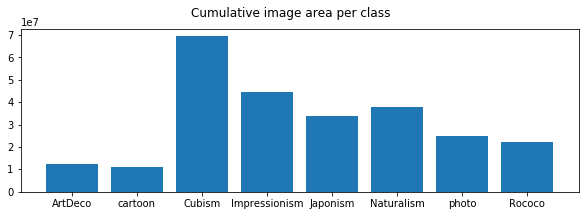

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(per_class_area.keys(), per_class_area.values())
fig.suptitle('Cumulative image area per class')
plt.show()

The resulting distribution of classes by area completely mirrors the distribution obtained above by count of class instances. Thus, we can conclude that the average area of the images for all classes does not differ significantly.

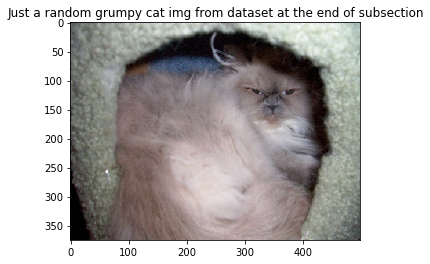

In [7]:
img = cv2.imread('images/photo/006512.jpg')[:,:,::-1]
plt.title('Just a random grumpy cat img from dataset at the end of subsection')
plt.imshow(img)
plt.show()

### 1.2. - Data preprocessing <a class="anchor" id="image-classifier-data-preprocessing"></a> 

In order to implement stratified test-train split approach it is natural to move all preprocessed files into a single directory and preapair `.csv` with image names and target class labels. Thus now we are going to use opencv to resize all images to $128\times 128$ pixels and save them in `dataset` directory. We will also utilize standard `OneHotEncoder` from` sklearn.preprocessing` to encode target labels.

In [8]:
bashCommand = "rm -r dataset"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
os.mkdir('dataset')

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(np.array(classes).reshape(-1, 1))

table_data = []
table_data.append(['id'] + ['label{}'.format(x) for x in range(0, nclasses)])

for cur_class in classes:
    for cur_img_name in per_class_names[cur_class]:
        
        # We also replace '_' symbol by '-' over all *.jpg in order to avoid potential conflict with LaTex 
        encoded_label = enc.transform(np.array(cur_class).reshape(-1, 1)).tolist()[0]
        table_data.append([cur_img_name.replace('_', '-')] + encoded_label)
        DIR = 'images/{}/{}'.format(cur_class, cur_img_name)
        OUTDIR = 'dataset/{}'.format(cur_img_name.replace('_', '-'))

        raw_img = cv2.imread(DIR)#[:,:,::-1]
        resized = cv2.resize(raw_img, (128, 128))
        cv2.imwrite(OUTDIR, resized)

column_names = table_data.pop(0)
df = pd.DataFrame(table_data, columns=column_names)
df.to_csv("dataset/labels.csv", index=False)

On the next step we will use `StratifiedKFold` from` sklearn.model_selection` to generate stratified train-test split in $ k = 4 $ folds.

In [9]:
fulldataset = pd.read_csv("dataset/labels.csv")

k=4

skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=False)
decoded_target = enc.inverse_transform(fulldataset[['label{}'.format(x) for x in range(0, nclasses)]].to_numpy())

for fold_id, (train_index, test_index) in enumerate(skf.split(fulldataset['id'].tolist(), 
                                                              decoded_target)):
    tmp_df_train = fulldataset.iloc[train_index]
    tmp_df_test = fulldataset.iloc[test_index]
    tmp_df_train.to_csv("dataset/train_fold{}.csv".format(fold_id), index=False)
    tmp_df_test.to_csv("dataset/test_fold{}.csv".format(fold_id), index=False)

Now we are about to prepare PyTorch wrapper for our data.

ref: [Dataset class tutorial in PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files "Creating a Custom Dataset for your files")

In [10]:
class ArtsImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_label_vectors = self.img_labels[['label{}'.format(tmp_i) for tmp_i in range(0, nclasses)]]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = ['ArtDeco', 'cartoon', 'Cubism', 'Impressionism', 'Japonism', 'Naturalism', 'photo', 'Rococo']

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = cv2.imread(img_path)[:,:,::-1]
        image = Image.open(img_path)
        label = torch.tensor((self.img_label_vectors.iloc[idx]).to_list())
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets, dataloaders, dataset_sizes = [], [], []
for fold_id in range(0, k):
    image_datasets.append({x: ArtsImageDataset("dataset/{}_fold{}.csv".format(x, fold_id), 
                                               'dataset', transform=data_transforms[x])
                      for x in ['train', 'test']})
    dataloaders.append({x: torch.utils.data.DataLoader(image_datasets[fold_id][x], batch_size=56,
                                            shuffle=True, num_workers=4)
                  for x in ['train', 'test']})

    dataset_sizes.append({x: len(image_datasets[fold_id][x]) for x in ['train', 'test']})

class_names = image_datasets[0]['train'].classes
dataset_sizes

[{'train': 1066, 'test': 356},
 {'train': 1066, 'test': 356},
 {'train': 1067, 'test': 355},
 {'train': 1067, 'test': 355}]

['photo', 'Naturalism', 'photo', 'Japonism', 'Cubism', 'Impressionism', 'Impressionism', 'Cubism', 'Impressionism', 'Japonism', 'Rococo', 'Rococo', 'Impressionism', 'Naturalism', 'Japonism', 'Cubism', 'Japonism', 'ArtDeco', 'Japonism', 'Japonism', 'photo', 'Cubism', 'photo', 'photo', 'ArtDeco', 'Naturalism', 'Naturalism', 'Rococo', 'Japonism', 'Cubism', 'Cubism', 'Cubism', 'Cubism', 'Japonism', 'Impressionism', 'Naturalism', 'Naturalism', 'Naturalism', 'Cubism', 'photo', 'Japonism', 'Impressionism', 'Cubism', 'Impressionism', 'Impressionism', 'Cubism', 'Impressionism', 'Impressionism', 'Impressionism', 'Impressionism', 'Rococo', 'Japonism', 'Impressionism', 'photo', 'Naturalism', 'Japonism']


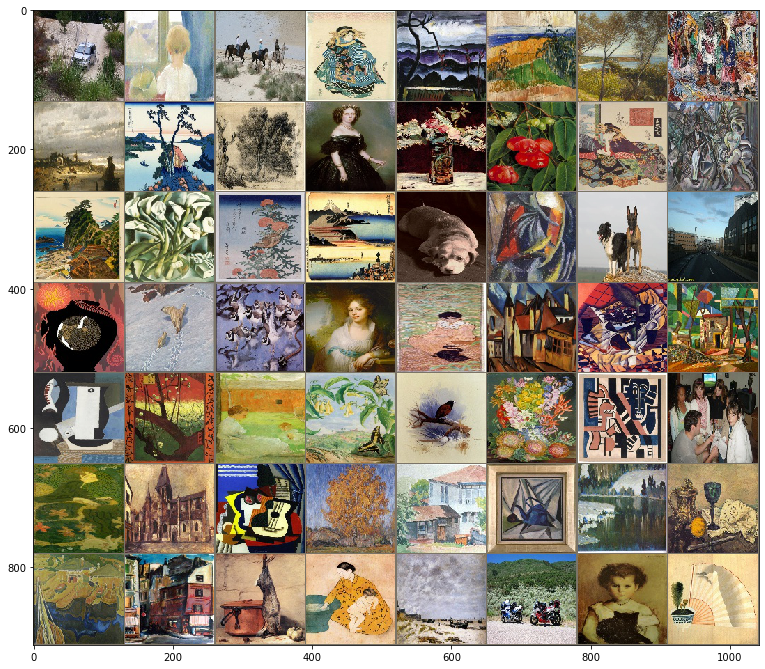

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(13, 13))
    ax.imshow(inp)
    if title is not None:
        print(title)


# Get a batch of training data
image_stream, labels_stream = next(iter(dataloaders[0]['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(image_stream)

imshow(out, title=[enc.inverse_transform(x.numpy().reshape(1, -1))[0, 0] for x in labels_stream])